# Setup

Before running any code, you will need to setup your codespace to work with Jupyter notebooks. Codespaces will do this for you when you try to run the first code cell. Click `Shift + Enter` in the following code cells, and follow the prompts at the top and/or bottom right of you page to install the python and jupyter extensions needed to run this notebook.

Select `Install/Enable suggested extensions python + jupyter` when it appears at the top of your page, and/or the "Install" button for the python extension on the bottom right of your page.

A circuluar arrow that looks like a clock will appear at the bottom left of your code cell while these install. This will take a minute or so. A circular arrow icon will also rotate near/in the top menu of your jupyter notebook.

After it install, you will either need to select the "Select Kernel" button at the top right of your notebook, or it will ask you to Select Kernel at the top of your page. Click Python Environments and the gprMax environment. Once everything is working correctly, the cell below should output the text in the parentheses just below the cell. 

In [1]:
print("My python environment is now working correctly! I am ready to run gprMax!")

My python environment is now working correctly! I am ready to run gprMax!


# A-scan from a metal cylinder (2D)
This notebook is heavily derived from GPRMax's tutorial notebooks, but with some key parameter changes.

This example is the GPR modelling equivalent of 'Hello World'! It demonstrates how to simulate a single trace (A-scan) from a metal cylinder buried in a dielectric half-space. The input for this model is located in the file: /workspaces/GEOL451/GPR/SyntheticGPR/GPRMax/GEOL451_GPRMaxFiles/GEOL451_Ascan_2D.in

### Geometry of a metal cylinder buried in a dielectric half-space
<img style="float: left" src="/workspaces/GEOL451/GPR/SyntheticGPR/GPRMax/gprMax/tools/Jupyter_notebooks/cylinder_half_space_geo.png" width="50%" height="50%" />


The geometry of the scenario is straightforward - the transparent area around the boundary of the domain represents the PML (i.e, the area being modeled) region. The red cell is the source and the blue cell is the receiver.

For this initial example a detailed description of what each command in the input file does and why each command was used is given. The following steps explain the process of building the input file:

## 1. Define the model's materials

There will be three different materials in the model: 
* air: air (free space) already exists as a built-in material in gprMax which can be accessed using the ``free_space`` identifier.
* a buried target (in this case, a metal cylinder):  the metal cylinder will be modeled as a Perfect Electric Conductor, a built-in material in gprMax that can be accessed using ``pec``. 
* dielectric half-space (a consistent subsurface material): we will define with the following parameters and an identifier of ``half_space``:
  * Non-magnetic: $\mu_r=1$ and $\sigma_*=0$ 
  * Relative permittivity of six: $\epsilon_r=6$, 
  * Zero conductivity, $\sigma=0$. 

This half-space is defined in the .in parameter file as: 
  * `#material: 6 0 1 0 half_space`


## 2. Determine the source type and excitation frequency

We will simulate the GPR antenna/source with the following characteristics:
* A theoretical Hertzian dipole source 
* A Ricker waveform
  * Amplitude of 1
  * Center frequency of $f_c=250~\textrm{MHz}$

In the .in parameter file, these are specified using:
  * `#waveform: ricker 1 250e6 my_ricker`
  * `#hertzian_dipole: z 0.100 0.170 0 my_ricker`

The Ricker waveform is created with the ``#waveform`` command, specifying an amplitude of one, centre frequency of 250 MHz and picking an arbitrary identifier of ``my_ricker``. The Hertzian dipole source is created using the ``#hertzian_dipole`` command, specifying a z direction polarisation (perpendicular to the survey direction if a B-scan were being created), location on the surface of the slab, and using the Ricker waveform already created.


## 3. Calculate a spatial resolution and domain size

One *rule-of-thumb* for GPR is that the spatial resolution is 1/10 of the smallest wavelength present in the model. 

To determine the smallest wavelength, the highest frequency and lowest velocity present in the model are required. The highest frequency is not the centre frequency of the Ricker waveform!  

You can use the following code to plot builtin waveforms and their FFTs.

Waveform characteristics...
Type: ricker
Maximum (absolute) amplitude: 1


Centre frequency: 2.5e+08 Hz
Time to centre of pulse: 5.65685e-09 s
Time window: 1e-08 s (5193 iterations)
Time step: 1.926e-12 s


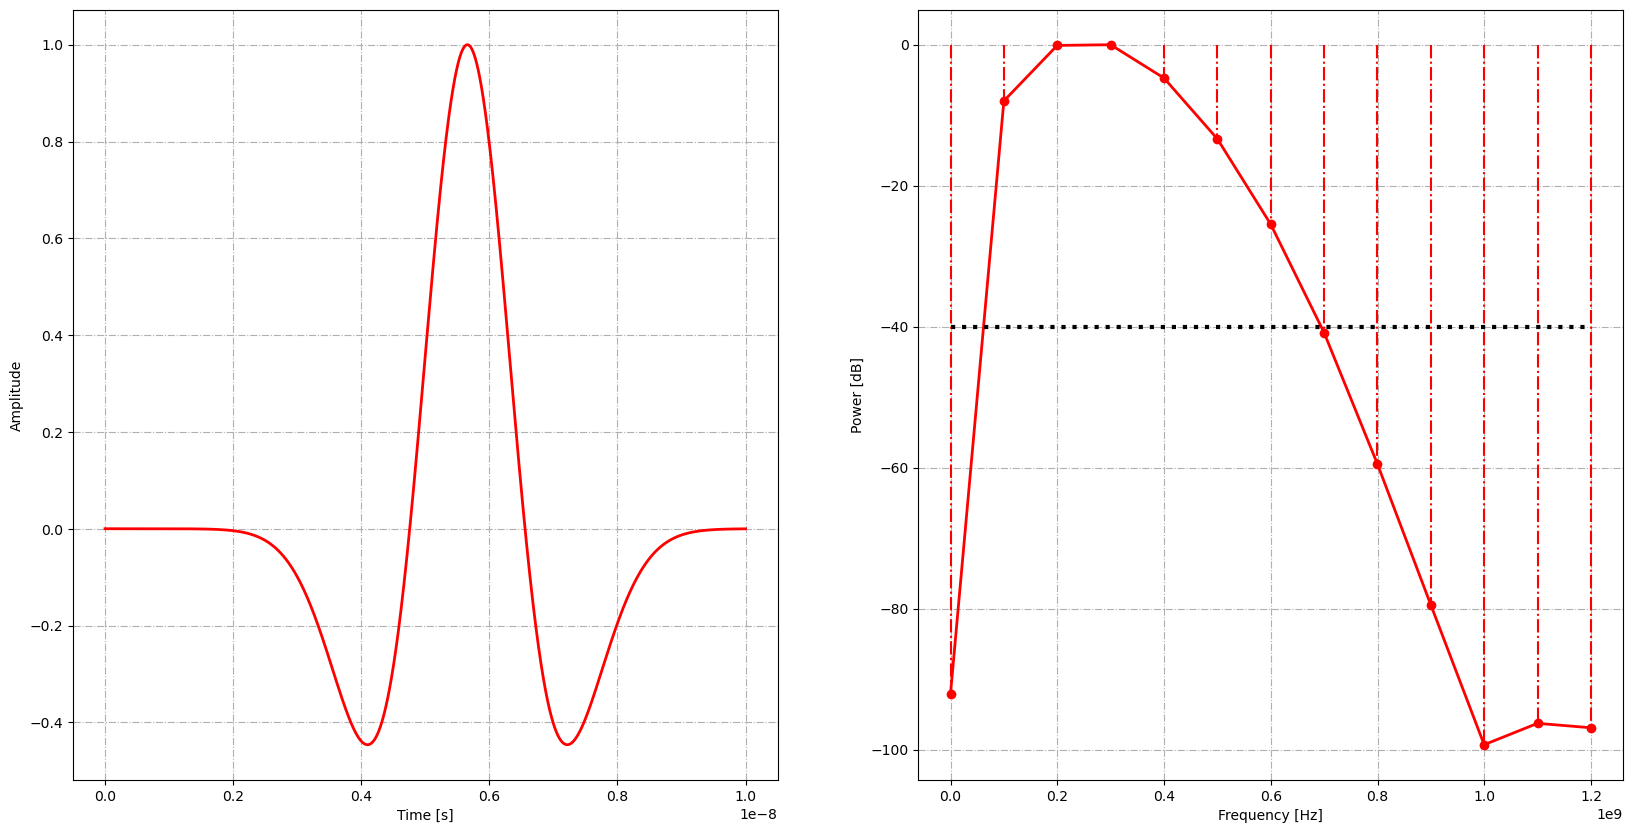

In [20]:
%matplotlib inline
from gprMax.waveforms import Waveform
from tools.plot_source_wave import check_timewindow, mpl_plot
import matplotlib.pyplot as plt

w = Waveform()
w.type = 'ricker'
w.amp = 1
w.freq = 250e6
timewindow = 1e-8
dt = 1.926e-12

timewindow, iterations = check_timewindow(timewindow, dt)
plt.close()
plt = mpl_plot(w, timewindow, dt, iterations, fft=True)
plt.hlines(y=[-40], xmin=0, xmax=1.2e9, linestyles='dotted', linewidths=3, colors='k')
plt.show()

The figure on the left shows the shape of the GPR pulse emitted from the transmitting antenna, and how much time it takes to complete a pulse at our input frequency.

The figure on the right shows the power at each frequency from the GPR pulse. This figure also includes a dotted line showing our (somewhat arbitrary) threshold for significant frequencies (i.e., those above -40dB). The frequencies with power values above this line are ~50MHz-700MHz (with a peak around our center frequency of 250MHz).

In this case the highest significant frequency present in the model is likely to be around 4 GHz. To calculate the wavelength at 700 MHz in the half-space (which has the lowest velocity) use:

$$\lambda = \frac{c}{f \sqrt{\epsilon_r}}$$

In [32]:
from math import sqrt

# Speed of light in vacuum (m/s)
c = 299792458

# Highest relative permittivity present in model
er = 6

# Maximum frequency present in model
fmax = 700e6

# Minimum wavelength
wmin = c / (fmax * sqrt(er))

# Maximum spatial resolution, using our 1/10 rule of thumb
dmin = wmin * (1 / 10)

# Calculate propogation velocity for non-magnetic material
prop_vel = c / sqrt(er)
prop_vel_mpns = prop_vel / 1e9 # Convert to meters/nanoseconds (commonly used for GPR)

print('Minimum wavelength: {:g} m'.format(wmin))
print('Maximum spatial resolution: {:g} m'.format(dmin))
print('Propogation velocity: {:g} m/ns'.format(prop_vel_mpns))

Minimum wavelength: 0.174843 m
Maximum spatial resolution: 0.0174843 m
Propogation velocity: 0.12239 m/ns


This would give a minimum spatial resolution of 17 mm. However, the diameter of the cylinder is 20 mm so would be resolved to essentially a single cell if we used our GPR resolution (17 mm) as our model resolution. 

Therefore a better choice for resulution might be 2 mm, which resolves the diameter of the rebar to 9 or so model cells. This is shown in the .in file as:

    * `#dx_dy_dz: 0.002 0.002 0.002`

The domain size should be enough to enclose the volume of interest, plus allow 10 cells for the edge of the model to "absorb" the GPR signal and approximately another 10 cells of between the edge of the model and any objects of interest. Since we will create a B-scan of this scenario below, our domain should be large enough for those parameters. 

To make this is a 2D model (instead of a 3D model), will define one cell as "infinite" by making it only one cell wide. This is how this is implemented in the gprMax input file:

    * `#domain: 0.240 0.210 0.002`

## 4. Choose a time window

In this model, we hope to model and see the expected reflection of a GPR signal from a buried metal cylinder, therefore the time window must be long enough to allow the electromagnetic waves to propagate from the source through the half-space to the cylinder *and* to be reflected back to the receiver.

In [26]:
target_depth = 0.090
two_way_travel_time = (2 * target_depth) / (c / sqrt(6)) # 2 times the depth (we need two-way travel time) divided by velocity
print('Minimum time window: {:g} s'.format(two_way_travel_time))

Minimum time window: 1.47071e-09 s


This is the minimum time required, but the source waveform has a width of (left figure above) about 10 ns. To allow for the entire source waveform to be reflected back to the receiver an initial time window of 15 ns will be used. This is defined in the .in parameter file as:

    * `#time_window: 15e-9`

The time step required for the model is automatically calculated using the CFL condition (for this case in 2D).


## 5. Create the GPR materials/objects

Now physical objects can be created for the half-space (i.e., the subsurface) and the cylinder. 

First the ``#box`` command will be used to create the half-space and then the ``#cylinder`` command will be given which will overwrite the properties of the half-space with those of the cylinder at the location of the cylinder. In the .in file, this is defined as follows:

  * `#box: 0 0 0 0.240 0.170 0.002 half_space`
  * `#cylinder: 0.120 0.080 0 0.120 0.080 0.002 0.010 pec`

# Run the model

You can now run the model using:
    
    python -m gprMax user_models/cylinder_Ascan_2D.in

**Tip**: You can use the ``--geometry-only`` command line argument to build a model and produce any geometry views but not run the simulation. This option is useful for checking the geometry of the model is correct.

In [14]:
import os
from gprMax.gprMax import api

parameter_filepath = r"/workspaces/GEOL451/GPR/SyntheticGPR/GPRMax/GEOL451_Ascan_2D.in"
#parameter_filepath = r"/workspaces/GEOL451/GPR/SyntheticGPR/GPRMax/gprMax/user_models/cylinder_Ascan_2D.in"
api(parameter_filepath, n=1, geometry_only=True)


=== Electromagnetic modelling software based on the Finite-Difference Time-Domain (FDTD) method 

    www.gprmax.com   __  __
     __ _ _ __  _ __|  \/  | __ ___  __
    / _` | '_ \| '__| |\/| |/ _` \ \/ /
   | (_| | |_) | |  | |  | | (_| |>  <
    \__, | .__/|_|  |_|  |_|\__,_/_/\_\
    |___/|_|
                     v3.1.7 (Big Smoke)

 Copyright (C) 2015-2023: The University of Edinburgh
 Authors: Craig Warren and Antonis Giannopoulos

 gprMax is free software: you can redistribute it and/or modify it under the
  terms of the GNU General Public License as published by the Free Software
  Foundation, either version 3 of the License, or (at your option) any later
  version.
 gprMax is distributed in the hope that it will be useful, but WITHOUT ANY
  WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR
  A PARTICULAR PURPOSE.  See the GNU General Public License for more details.
 You should have received a copy of the GNU General Public License along with
  gpr

## View the results

### Plot the A-scan

You should have produced an output file ``cylinder_Ascan_2D.out``. You can view the results using:

    python -m tools.plot_Ascan user_models/cylinder_Ascan_2D.out
    
You can use the following code to experiment with plotting different field/current components.

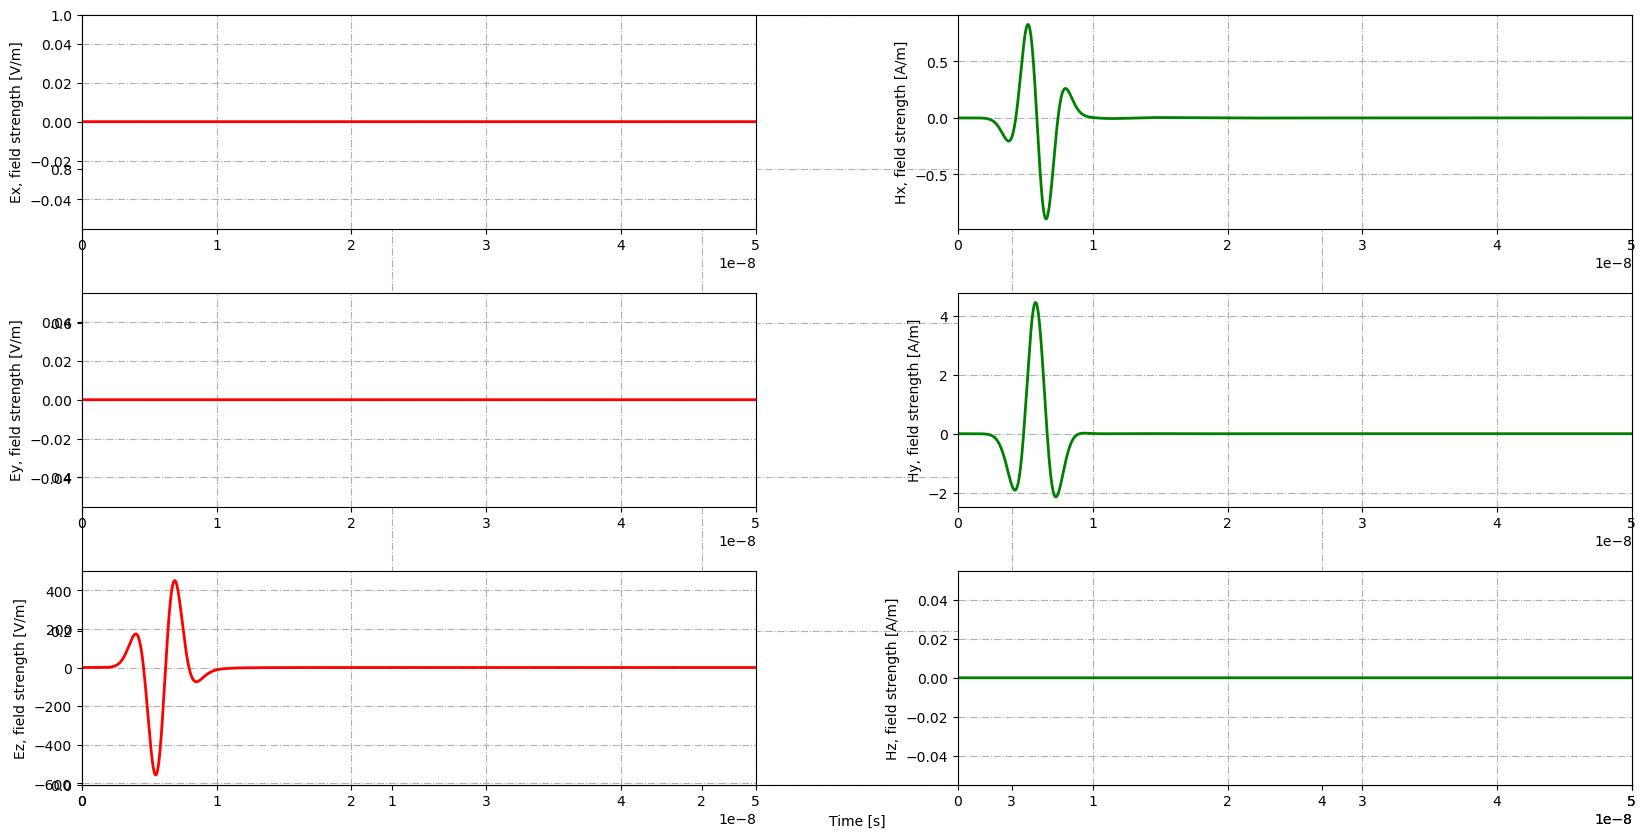

In [15]:
%matplotlib inline
from gprMax.receivers import Rx
from tools.plot_Ascan import mpl_plot
import matplotlib.pyplot as plt

outputFilepath = r"/workspaces/GEOL451/GPR/SyntheticGPR/GPRMax/GEOL451_Ascan_2D.out"
#outputFilepath = r"/workspaces/GEOL451/GPR/SyntheticGPR/GPRMax/gprMax/user_models/cylinder_Ascan_2D.out"
outputs = Rx.defaultoutputs
#outputs = ['Ez']
plt.close()
plt = mpl_plot(outputFilepath, outputs, fft=False)
plt.show()


=== Electromagnetic modelling software based on the Finite-Difference Time-Domain (FDTD) method 

    www.gprmax.com   __  __
     __ _ _ __  _ __|  \/  | __ ___  __
    / _` | '_ \| '__| |\/| |/ _` \ \/ /
   | (_| | |_) | |  | |  | | (_| |>  <
    \__, | .__/|_|  |_|  |_|\__,_/_/\_\
    |___/|_|
                     v3.1.7 (Big Smoke)

 Copyright (C) 2015-2023: The University of Edinburgh
 Authors: Craig Warren and Antonis Giannopoulos

 gprMax is free software: you can redistribute it and/or modify it under the
  terms of the GNU General Public License as published by the Free Software
  Foundation, either version 3 of the License, or (at your option) any later
  version.
 gprMax is distributed in the hope that it will be useful, but WITHOUT ANY
  WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR
  A PARTICULAR PURPOSE.  See the GNU General Public License for more details.
 You should have received a copy of the GNU General Public License along with
  gpr

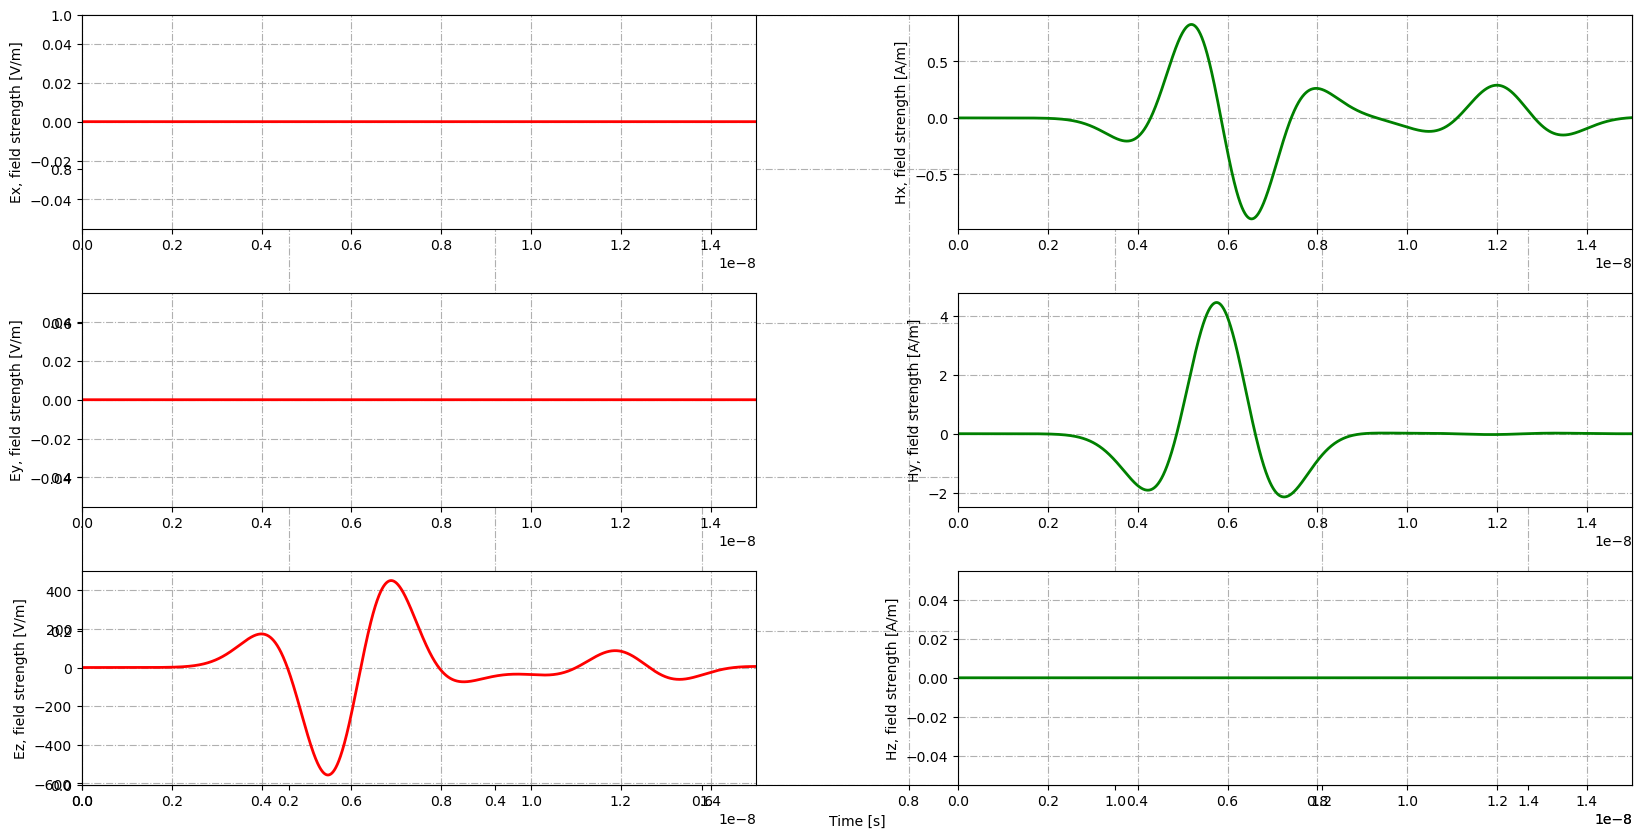

In [8]:

import os
from gprMax.gprMax import api

parameter_filepath = r"/workspaces/GEOL451/GPR/SyntheticGPR/GPRMax/GEOL451_Ascan_2D.in"
#parameter_filepath = r"/workspaces/GEOL451/GPR/SyntheticGPR/GPRMax/gprMax/user_models/cylinder_Ascan_2D.in"
api(parameter_filepath, n=1, geometry_only=False)


%matplotlib inline
from gprMax.receivers import Rx
from tools.plot_Ascan import mpl_plot
import matplotlib.pyplot as plt

outputFilepath = r"/workspaces/GEOL451/GPR/SyntheticGPR/GPRMax/GEOL451_Ascan_2D.out"
#outputFilepath = r"/workspaces/GEOL451/GPR/SyntheticGPR/GPRMax/gprMax/user_models/cylinder_Ascan_2D.out"
outputs = Rx.defaultoutputs
#outputs = ['Ez']
plt.close()
plt = mpl_plot(outputFilepath, outputs, fft=False)
plt.show()

## Calculate target depth

Now, we can back-calculate our target depth based on these plots and our previously-calculated propogation velocity of about 0.122 m/ns. We will focus on the bottom left chart for now (the electrical field in the Z-polarization).

In the bottom-left chart, the signal as read by the receiving transmitter peaks at about 7 nanoseconds. To calculate the depth to the target, we will multiply the time it took to reach the target 

In [19]:
time = 0.115 - 0.056 #ns
expect_distance = 0.5 - 0.05
vel = 0.122
calc_dist = time/vel
print(calc_dist, expect_distance)

0.4836065573770492 0.45
